In [14]:
%load_ext autoreload
%autoreload 2

from deltas.pipeline import data, classifier, evaluation
from deltas.model import base, downsample
import deltas.plotting.plots as plots
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# np.random.seed(10)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:

N1 = 1000
m = 1
v = 1
runs = [6, 8, 10, 15, 20, 25, 30, 35, 50, 70, 100, 200, 500]
results = {}
for run in tqdm(runs):
    N2 = run
    dfs = []
    while len(dfs) < 2:
        data_clf = data.get_data(
            m1=[-m, -m],
            m2=[m, m],
            cov1=[[v, 0], [0, v]],
            cov2=[[v, 0], [0, v]],
            N1=N1,
            N2=N2,
            scale=False,
            test_nums=[10000, 10000],
        )

        model = 'SVM-linear'
        model = 'SVM-rbf'
        model = 'MLP'
        model = 'MLP-Gaussian'
        model = 'Linear'

        classifiers_dict = classifier.get_classifier(
            data_clf=data_clf,
            model=model,
            _plot=False)
        data_clf['clf'] = classifiers_dict['Baseline']
        X = data_clf['data']['X']
        y = data_clf['data']['y']
        clf = data_clf['clf']
        # deltas_model = downsample.downsample_deltas(
        #     clf).fit(X, y, _print=True, _plot=True, max_trials=10000)
        # deltas_model = base.base_deltas(
        #     clf).fit(X, y, grid_search=True, _print=True, _plot=True)
        deltas_model = downsample.downsample_deltas(clf).fit(X, y,
                                                            alpha=1,
                                                            _print=False,
                                                            _plot=False,
                                                            method='supports-prop-update_mean',
                                                            max_trials=10000,
                                                            parallel=True)

        if deltas_model.is_fit == True:
            classifiers_dict['Our Method'] = deltas_model
            scores_df = evaluation.eval_test(classifiers_dict,
                                            data_clf['data_test'], _print=False, _plot=False)
            dfs.append(scores_df)
        else:
            print('not fit deltas')
    results[run] = dfs

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:19<01:28,  9.86s/it]

not fit deltas


100%|██████████| 11/11 [02:04<00:00, 11.29s/it]


In [16]:
print(results[runs[0]])

[                  Accuracy    G-Mean        F1
Method                                        
Baseline           0.59990  0.447169  0.333278
SMOTE              0.91595  0.915902  0.915157
Balanced Weights   0.91205  0.912043  0.912361
BMR                0.82100  0.803249  0.784389
Threshold          0.82100  0.803249  0.784389
Our Method         0.91835  0.917946  0.920516,                   Accuracy    G-Mean        F1
Method                                        
Baseline           0.66750  0.579365  0.502618
SMOTE              0.89195  0.889084  0.883636
Balanced Weights   0.89590  0.894110  0.889654
BMR                0.90640  0.905175  0.901774
Threshold          0.90640  0.905175  0.901774
Our Method         0.91315  0.912442  0.916164]


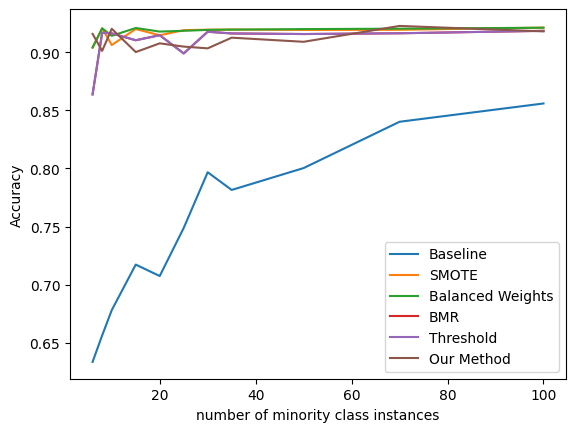

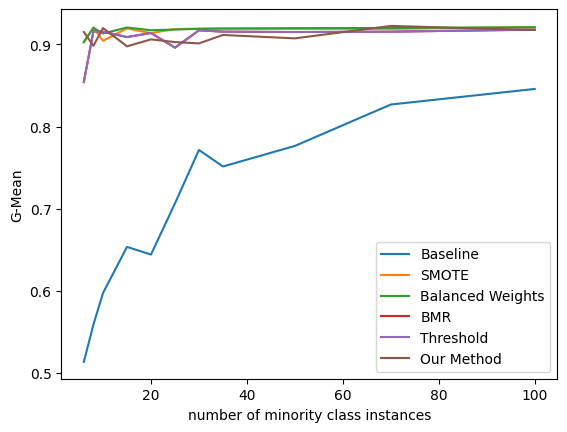

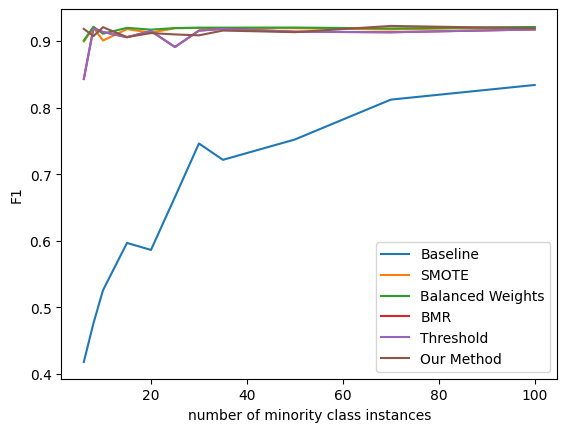

In [17]:
# setup data storage for plots
metrics = results[runs[0]][0].columns.to_list()
methods = results[runs[0]][0].index.to_list()
plot_info = {}
for metric in metrics:
    plot_info[metric] = {}
    for method in methods:
        plot_info[metric][method] = []

# extract data for plotting
for run in runs:
    dfs = results[run]
    df = pd.concat(dfs, axis=0)
    mean = {}
    std = {}
    index = df.index.unique().to_list()
    cols = df.columns.to_list()
    for method in index:
        mean[method] = df.loc[method].mean().to_list()
        std[method] = df.loc[method].std().to_list()
    for metric in cols:
        for method in mean.keys():
            plot_info[metric][method].append(mean[method][cols.index(metric)])
    
# plot 
for metric in metrics:
    for method in methods:
        plt.plot(runs, plot_info[metric][method], label=method)
    plt.legend()
    plt.ylabel(metric)
    plt.xlabel('number of minority class instances')
    plt.show()